In [1]:
import os
os.chdir('../')

In [2]:
from IPython.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import torch
import torchvision.transforms as transforms
from lateral_connections.loaders import load_mnistc

folder_paths = ['experiment_results/experiment__tcnn_tln__best']
df = None

for folder_path in folder_paths:
    for file in os.listdir(folder_path):
        if not file.endswith('.csv'):
            continue

        full_path = os.path.join(folder_path, file)

        df_tmp = pd.read_csv(full_path)

        if df is None:
            df = df_tmp
        else:
            df = df.append(df_tmp)

df = df.reset_index()
#df = df[df.model_type != 'TinyCNN']

df

,index,model,mnist_c_variant,accuracy,model_type
0,0,2022-07-05_110547,identity,0.9751,TinyLateralNet__FullyTrained__d1
1,1,2022-07-05_110547,pixelate,0.9554,TinyLateralNet__FullyTrained__d1
2,2,2022-07-05_110547,dotted_line,0.9142,TinyLateralNet__FullyTrained__d1
3,3,2022-07-05_110547,gaussian_blur,0.8819,TinyLateralNet__FullyTrained__d1
4,4,2022-07-05_110547,elastic_transform,0.6977,TinyLateralNet__FullyTrained__d1
...,...,...,...,...,...
1275,27,2022-07-04_213210,inverse,0.0990,TinyCNN_PreTrained
1276,28,2022-07-04_213210,impulse_noise,0.1436,TinyCNN_PreTrained
1277,29,2022-07-04_213210,stripe,0.3046,TinyCNN_PreTrained
1278,30,2022-07-04_213210,quantize,0.9466,TinyCNN_PreTrained


In [4]:
df_group_by = df.groupby(['model'])
df_group_by.count()['accuracy']
df.model_type.unique()

array(['TinyLateralNet__FullyTrained__d1', 'TinyLateralNet__FullyTrained',
       'TinyLateralNet__PreTrained', 'TinyCNN_FullyTrained',
       'TinyCNN_PreTrained'], dtype=object)

In [5]:
df_cnn = df[df.model_type == 'TinyCNN_FullyTrained']
df_cnn_pt = df[df.model_type == 'TinyCNN_PreTrained']
df_tln = df[df.model_type == 'TinyLateralNet__FullyTrained']
df_tln_pt = df[df.model_type == 'TinyLateralNet__PreTrained']
df_tln_d1 = df[df.model_type == 'TinyLateralNet__FullyTrained__d1']

a = df_cnn.groupby(['mnist_c_variant'])
b = df_tln.groupby(['mnist_c_variant'])

c = df_cnn_pt.groupby(['mnist_c_variant'])
d = df_tln_pt.groupby(['mnist_c_variant'])

e = df_tln_d1.groupby(['mnist_c_variant'])

def calc_improvement(row):
    if row['cnn_acc_median'] + row['cnn_acc_std'] < row['lcl_acc_median'] - row['lcl_acc_std']:
        return 1
    elif row['cnn_acc_median'] - row['cnn_acc_std'] > row['lcl_acc_median'] + row['lcl_acc_std']:
        return -1
    else:
        return 0

x = pd.DataFrame(df_cnn.mnist_c_variant.unique(), columns=['mnist_c_variant'])

x = x.join(a.mean()['accuracy'].round(4), on='mnist_c_variant')
x = x.rename(columns={'accuracy': 'cnn_ft_acc_median'})
x = x.join(a.std()['accuracy'].round(4), on='mnist_c_variant')
x = x.rename(columns={'accuracy': 'cnn_ft_acc_std'})

x = x.join(b.mean()['accuracy'].round(4), on='mnist_c_variant')
x = x.rename(columns={'accuracy': 'lcl_ft_acc_median'})
x = x.join(b.std()['accuracy'].round(4), on='mnist_c_variant')
x = x.rename(columns={'accuracy': 'lcl_ft_acc_std'})

x = x.join(c.mean()['accuracy'].round(4), on='mnist_c_variant')
x = x.rename(columns={'accuracy': 'cnn_pt_acc_median'})
x = x.join(c.std()['accuracy'].round(4), on='mnist_c_variant')
x = x.rename(columns={'accuracy': 'cnn_pt_acc_std'})

x = x.join(d.mean()['accuracy'].round(4), on='mnist_c_variant')
x = x.rename(columns={'accuracy': 'lcl_pt_acc_median'})
x = x.join(d.std()['accuracy'].round(4), on='mnist_c_variant')
x = x.rename(columns={'accuracy': 'lcl_pt_acc_std'})

x = x.join(e.mean()['accuracy'].round(4), on='mnist_c_variant')
x = x.rename(columns={'accuracy': 'lcl_ft_d1_acc_median'})
x = x.join(e.std()['accuracy'].round(4), on='mnist_c_variant')
x = x.rename(columns={'accuracy': 'lcl_ft_d1_acc_std'})

#x['improvement'] = x.apply(calc_improvement, axis=1)

#df_imp = x.sort_values(['improvement', 'cnn_acc_median'], ascending=[False, False]).reset_index(drop=True)
x = x[['mnist_c_variant','cnn_ft_acc_median','cnn_ft_acc_std','cnn_pt_acc_median','cnn_pt_acc_std','lcl_ft_acc_median','lcl_ft_acc_std','lcl_pt_acc_median','lcl_pt_acc_std','lcl_ft_d1_acc_median','lcl_ft_d1_acc_std']]
df_imp = x.sort_values(['cnn_ft_acc_median'], ascending=False).reset_index(drop=True)
df_imp[['mnist_c_variant','lcl_ft_acc_median','lcl_ft_acc_std','lcl_ft_d1_acc_median','lcl_ft_d1_acc_std']]
df_imp


,mnist_c_variant,cnn_ft_acc_median,cnn_ft_acc_std,cnn_pt_acc_median,cnn_pt_acc_std,lcl_ft_acc_median,lcl_ft_acc_std,lcl_pt_acc_median,lcl_pt_acc_std,lcl_ft_d1_acc_median,lcl_ft_d1_acc_std
0,identity,0.9828,0.0017,0.9840,0.0008,0.9730,0.0047,0.9745,0.0019,0.9543,0.0339
1,jpeg_compression,0.9774,0.0021,0.9781,0.0005,0.9690,0.0039,0.9414,0.0052,0.9477,0.0296
2,quantize,0.9643,0.0086,0.9489,0.0028,0.9670,0.0064,0.8380,0.0151,0.9464,0.0348
3,spatter,0.9620,0.0025,0.9587,0.0016,0.9438,0.0040,0.7781,0.0163,0.8971,0.0218
4,shear,0.9418,0.0030,0.9396,0.0033,0.9192,0.0145,0.9159,0.0087,0.8789,0.0610
5,pixelate,0.9385,0.0090,0.9182,0.0045,0.9349,0.0166,0.9144,0.0076,0.9304,0.0358
6,zoom_blur,0.9300,0.0182,0.9086,0.0100,0.9186,0.0165,0.8438,0.0193,0.8561,0.1011
7,speckle_noise,0.9107,0.0218,0.8172,0.0149,0.9653,0.0066,0.7388,0.0232,0.9378,0.0371
8,pessimal_noise,0.8842,0.0292,0.8088,0.0109,0.8072,0.0771,0.6851,0.0210,0.8290,0.0529
9,shot_noise,0.8806,0.0299,0.7551,0.0194,0.9627,0.0068,0.6663,0.0289,0.9303,0.0387


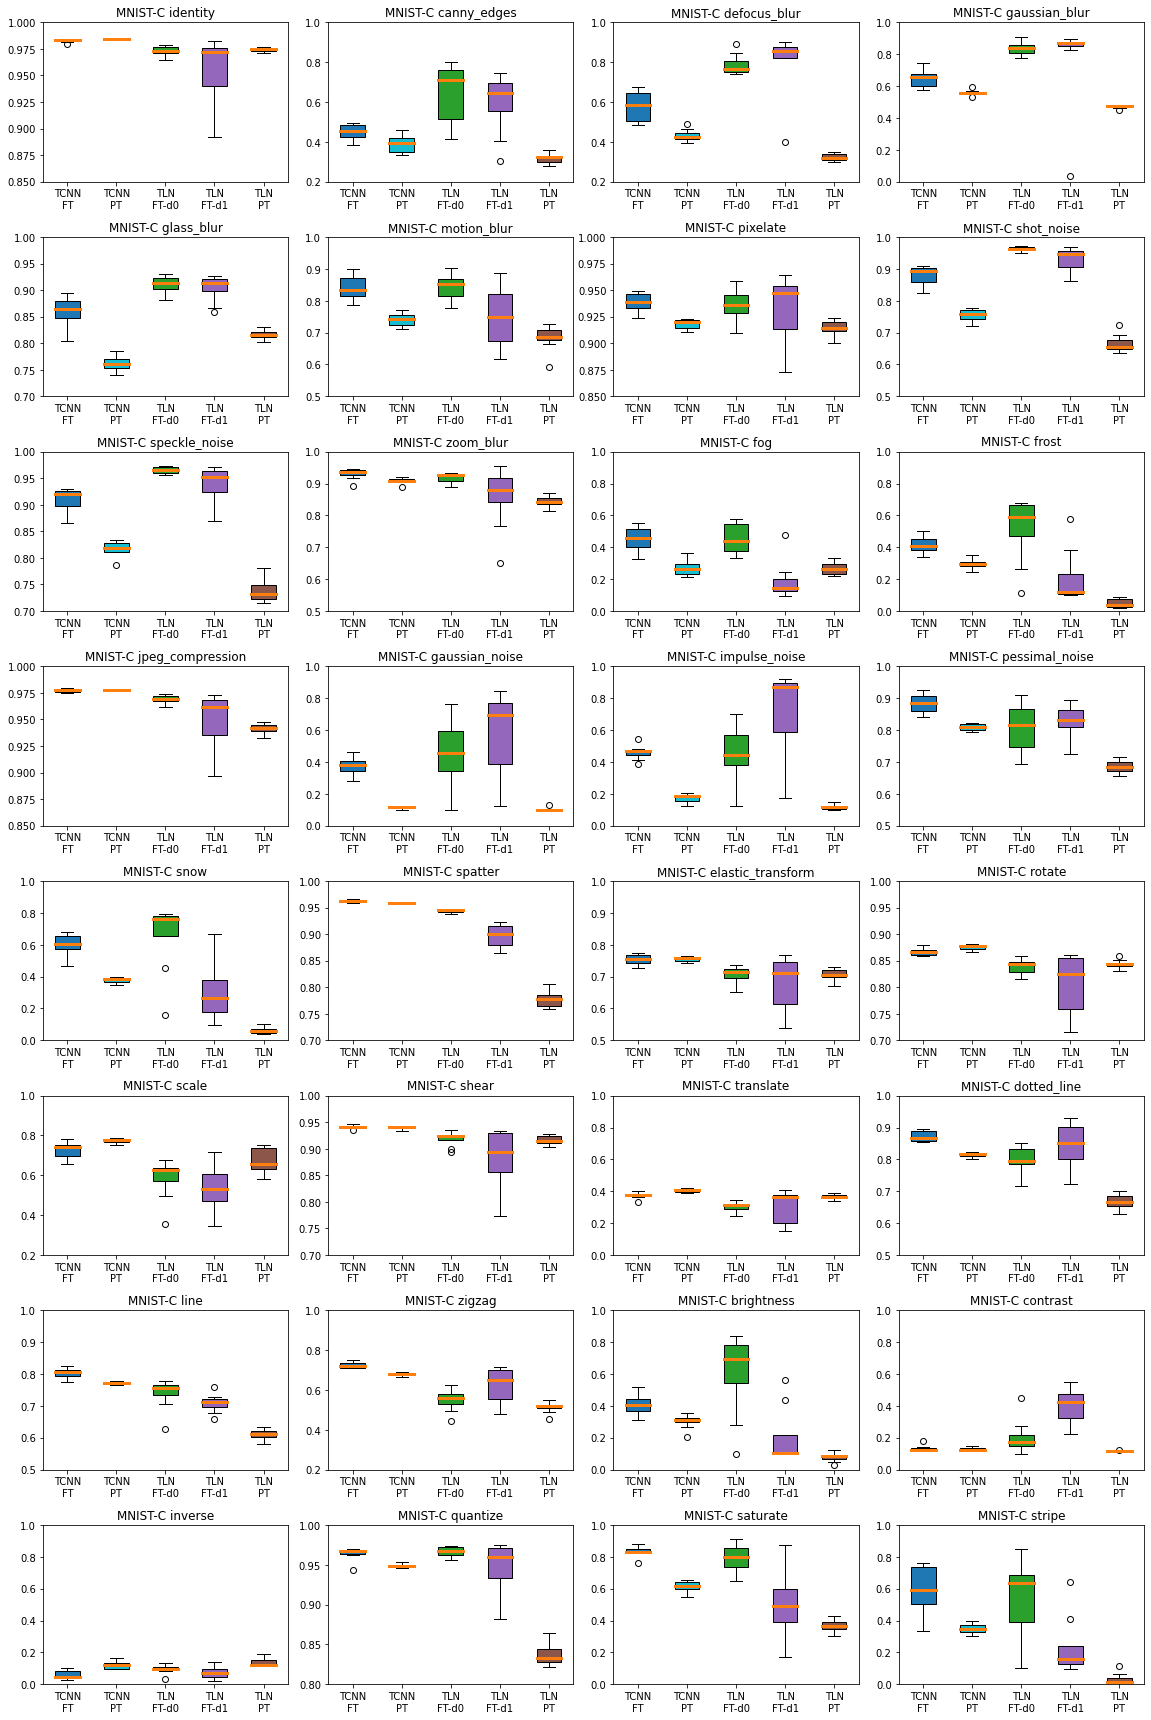

In [6]:
variants = df.sort_values('accuracy', ascending=False)['mnist_c_variant'].unique()
#models = ['TinyCNN_Finetuned', 'TinyLateralNet_OutputAdjusted']
models = ['TinyCNN_FullyTrained', 'TinyCNN_PreTrained', 'TinyLateralNet__FullyTrained', 'TinyLateralNet__FullyTrained__d1', 'TinyLateralNet__PreTrained']
variant_eval = dict()

fig, axs = plt.subplots(8, 4, figsize=(4*4, 3*8))

ordered_variants = ['identity', 'canny_edges', 'defocus_blur', 'gaussian_blur',
       'glass_blur', 'motion_blur', 'pixelate', 'shot_noise',
       'speckle_noise', 'zoom_blur', 'fog', 'frost', 'jpeg_compression',
       'gaussian_noise', 'impulse_noise', 'pessimal_noise', 'snow',
       'spatter', 'elastic_transform', 'rotate', 'scale', 'shear',
       'translate', 'dotted_line', 'line', 'zigzag', 'brightness',
       'contrast', 'inverse', 'quantize', 'saturate', 'stripe']

new_colors = ['tab:blue', 'tab:cyan', 'tab:green', 'tab:purple', 'tab:brown']

for y in range(4):
    for x in range(8):        
        idx = y + 4 * x
        variant = ordered_variants[idx]
        
        df_tmp = df[df.mnist_c_variant == variant]
        df_tmp

        vals = []
        for model in models:
            df_tmp2 = df_tmp[df_tmp.model_type == model]
            vals.append(df_tmp2['accuracy'].to_numpy())
            
        bplot = axs[x,y].boxplot(vals, medianprops=dict(linewidth=3), patch_artist=True, vert=True)
        axs[x,y].set_title('MNIST-C ' + variant)
        axs[x,y].set_xticklabels(['TCNN\nFT', 'TCNN\nPT', 'TLN\nFT-d0', 'TLN\nFT-d1', 'TLN\nPT'])
        axs[x,y].set_ylim(top=1)
        
        cmap = cm.get_cmap('viridis')
        for patch, color in zip(bplot['boxes'], new_colors):
            patch.set_facecolor(color)
        
        mins = [np.min(lst) for lst in vals]
        if np.min(mins) > 0.9:
            bottom = 0.9
        elif np.min(mins) > 0.85:
            bottom = 0.85
        elif np.min(mins) > 0.8:
            bottom = 0.8
        elif np.min(mins) > 0.7:
            bottom = 0.7
        elif np.min(mins) > 0.5:
            bottom = 0.5
        elif np.min(mins) > 0.2:
            bottom = 0.2
        else:
            bottom = 0.0
            
        axs[x,y].set_ylim(bottom=bottom)
        
        #if vals[0].mean() > vals[1].mean() or vals[0].mean() > vals[2].mean():
        if np.median(vals[0]) > np.median(vals[1]):
            variant_eval[variant] = False
            color = ':b'
        else:
            variant_eval[variant] = True
            color = ':y'

plt.tight_layout()
plt.savefig('tiny_lateral_net__comparison__d.png')

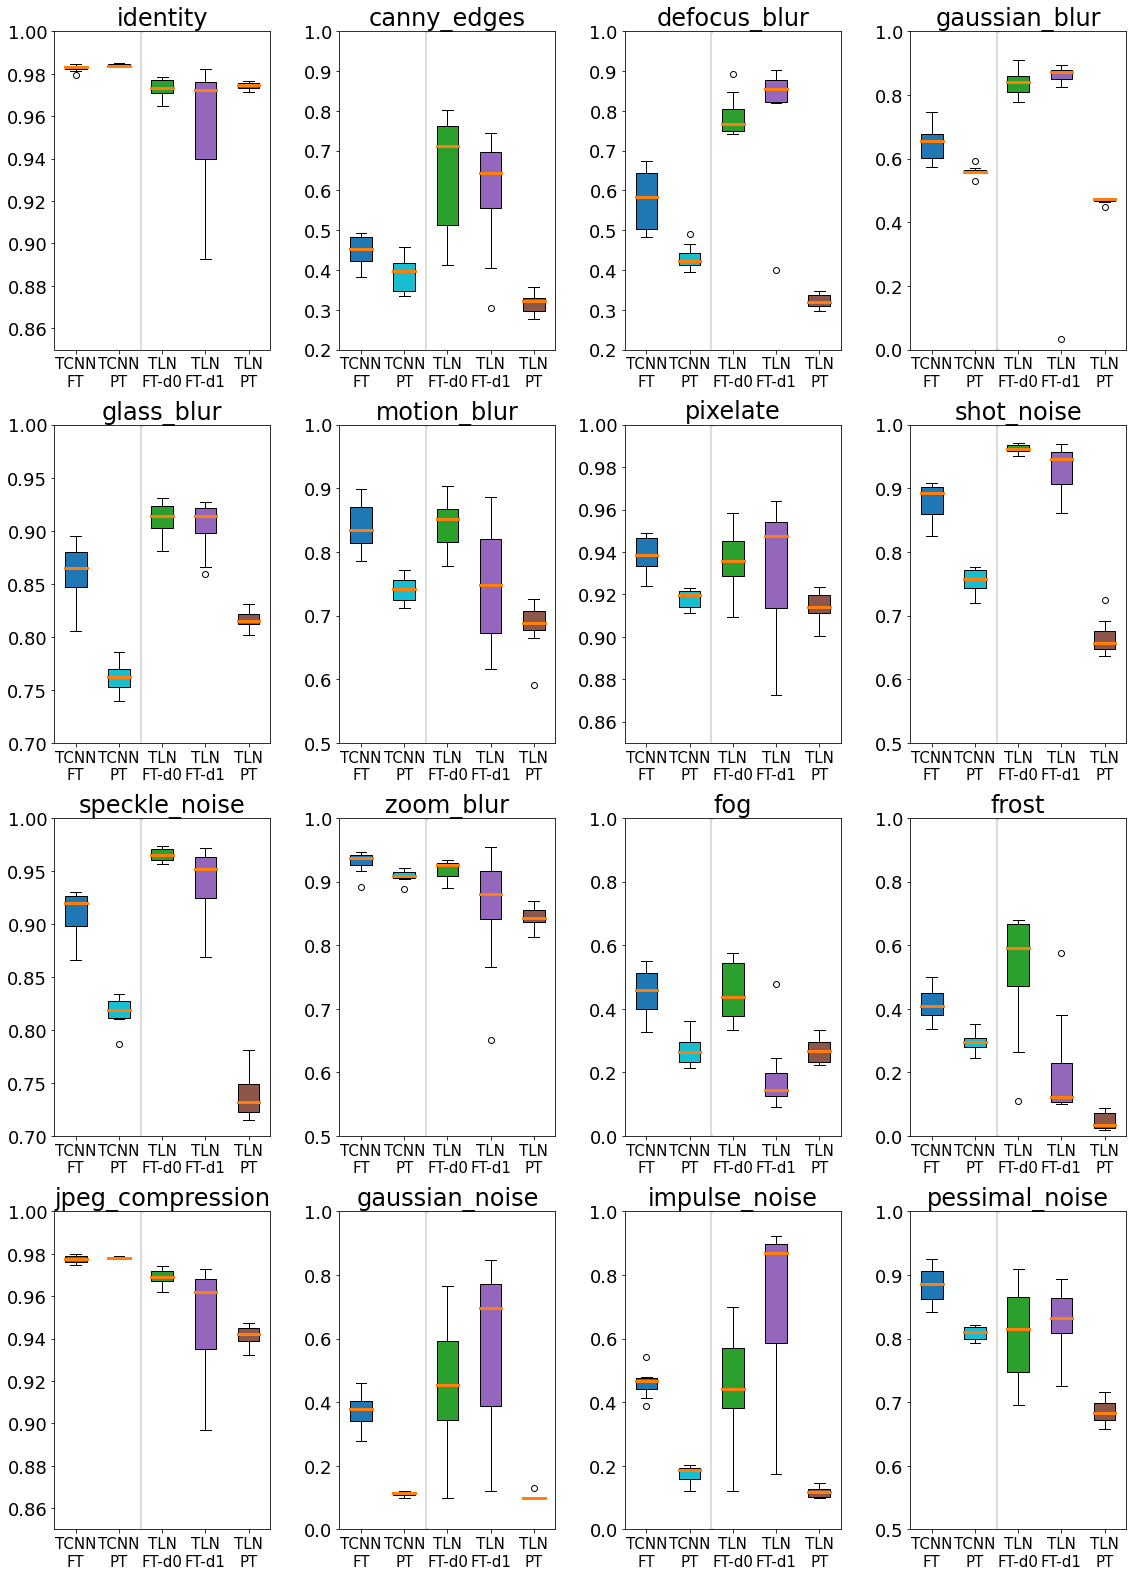

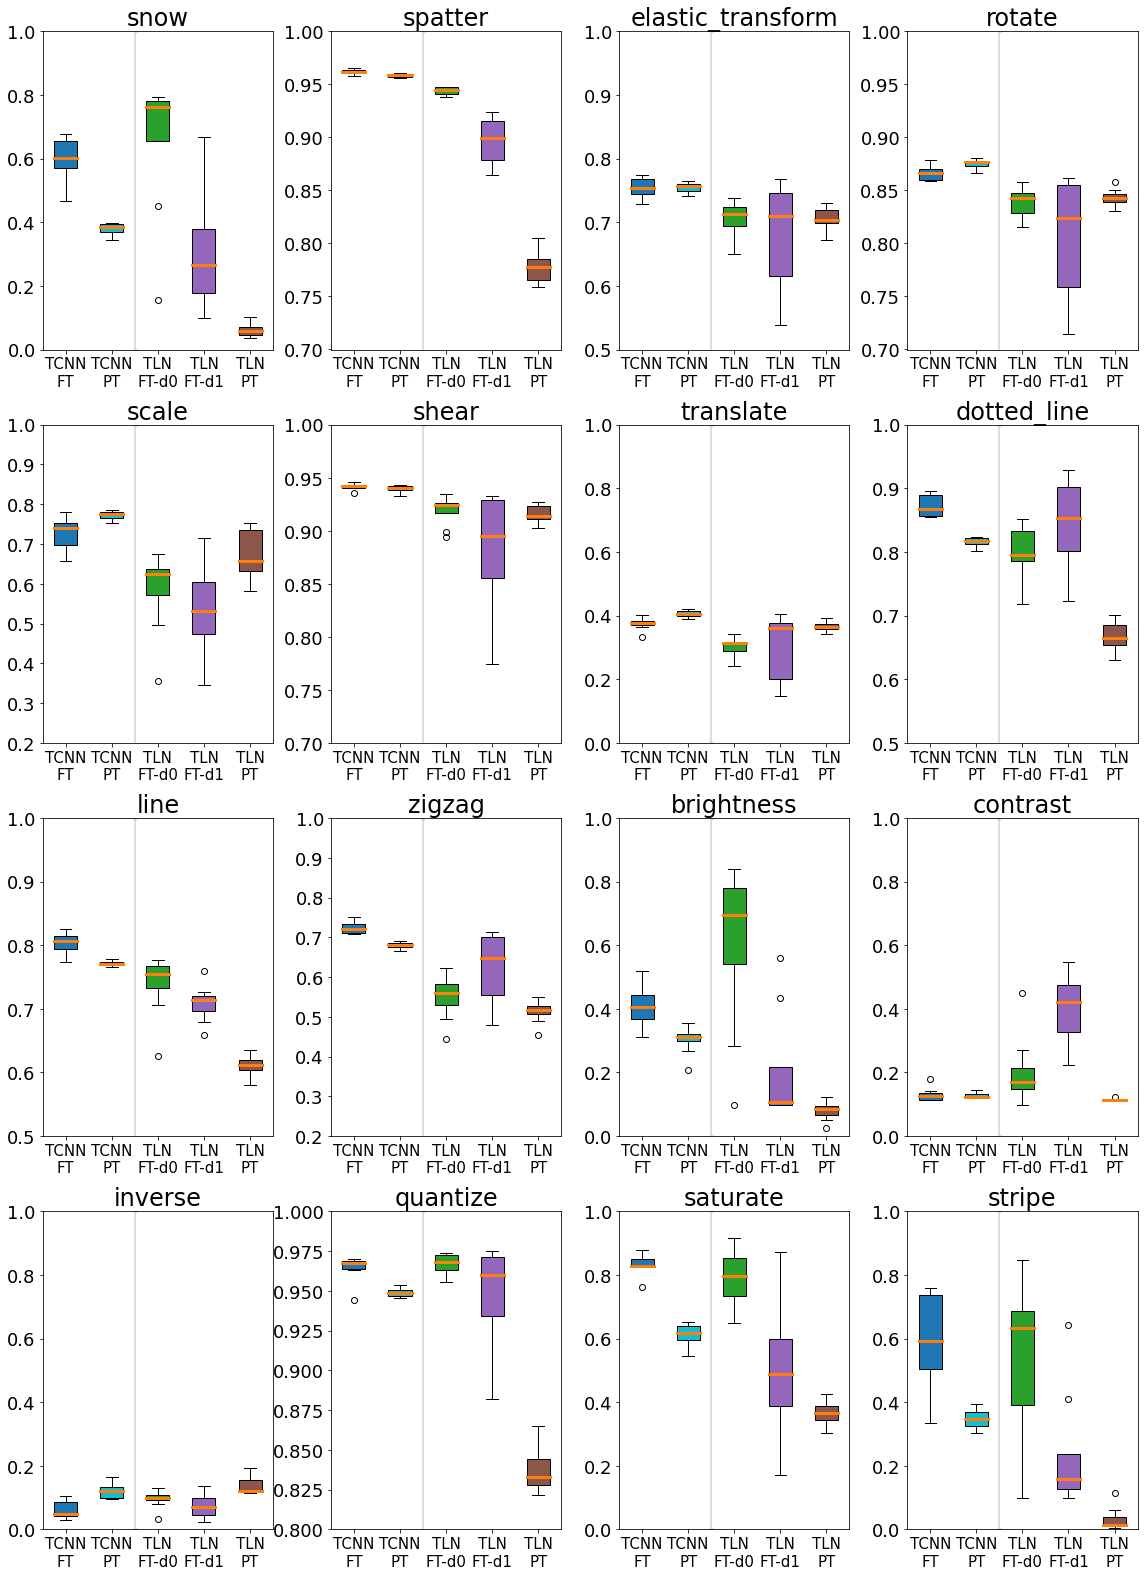

In [9]:
fig, axs = plt.subplots(4, 4, figsize=(4*4, 5.5*4))

for y in range(4):
    for x in range(4):        
        idx = y + 4 * x
        variant = ordered_variants[idx]
        
        df_tmp = df[df.mnist_c_variant == variant]
        df_tmp

        vals = []
        for model in models:
            df_tmp2 = df_tmp[df_tmp.model_type == model]
            vals.append(df_tmp2['accuracy'].to_numpy())
            
        bplot = axs[x,y].boxplot(vals, medianprops=dict(linewidth=3), patch_artist=True, vert=True)
        axs[x,y].set_title(variant, fontsize=24)
        axs[x,y].set_xticklabels(['TCNN\nFT', 'TCNN\nPT', 'TLN\nFT-d0', 'TLN\nFT-d1', 'TLN\nPT'], fontsize=15)
        axs[x,y].set_ylim(top=1)
        axs[x,y].yaxis.set_tick_params(labelsize=18)
        axs[x,y].plot([2.5, 2.5], [0, 1], '.-', color='lightgray')
        
        cmap = cm.get_cmap('viridis')
        for patch, color in zip(bplot['boxes'], new_colors):
            patch.set_facecolor(color)
            
        mins = [np.min(lst) for lst in vals]
        if np.min(mins) > 0.95:
            bottom = 0.95
        elif np.min(mins) > 0.9:
            bottom = 0.9
        elif np.min(mins) > 0.85:
            bottom = 0.85
        elif np.min(mins) > 0.8:
            bottom = 0.8
        elif np.min(mins) > 0.7:
            bottom = 0.7
        elif np.min(mins) > 0.5:
            bottom = 0.5
        elif np.min(mins) > 0.2:
            bottom = 0.2
        else:
            bottom = 0.0
        axs[x,y].set_ylim(bottom=bottom)
        
        #if vals[0].mean() > vals[1].mean() or vals[0].mean() > vals[2].mean():
        if np.median(vals[0]) > np.median(vals[1]):
            variant_eval[variant] = False
            color = ':b'
        else:
            variant_eval[variant] = True
            color = ':y'

plt.tight_layout()
plt.savefig('tiny_lateral_net__comparison__d__p1.png')

fig, axs = plt.subplots(4, 4, figsize=(4*4, 5.5*4))

for y in range(4):
    for x in range(4):        
        idx = y + 4 * x + 16
        variant = ordered_variants[idx]
        
        df_tmp = df[df.mnist_c_variant == variant]
        df_tmp

        vals = []
        for model in models:
            df_tmp2 = df_tmp[df_tmp.model_type == model]
            vals.append(df_tmp2['accuracy'].to_numpy())
            
        bplot = axs[x,y].boxplot(vals, medianprops=dict(linewidth=3), patch_artist=True, vert=True)
        axs[x,y].set_title(variant, fontsize=24)
        axs[x,y].set_xticklabels(['TCNN\nFT', 'TCNN\nPT', 'TLN\nFT-d0', 'TLN\nFT-d1', 'TLN\nPT'], fontsize=15)
        axs[x,y].set_ylim(top=1)
        axs[x,y].yaxis.set_tick_params(labelsize=18)
        axs[x,y].plot([2.5, 2.5], [0, 1], '.-', color='lightgray')
        
        cmap = cm.get_cmap('viridis')
        for patch, color in zip(bplot['boxes'], new_colors):
            patch.set_facecolor(color)
        
        mins = [np.min(lst) for lst in vals]
        if np.min(mins) > 0.95:
            bottom = 0.95
        elif np.min(mins) > 0.9:
            bottom = 0.9
        elif np.min(mins) > 0.85:
            bottom = 0.85
        elif np.min(mins) > 0.8:
            bottom = 0.8
        elif np.min(mins) > 0.7:
            bottom = 0.7
        elif np.min(mins) > 0.5:
            bottom = 0.5
        elif np.min(mins) > 0.2:
            bottom = 0.2
        else:
            bottom = 0.0
        axs[x,y].set_ylim(bottom=bottom)
        
        #if vals[0].mean() > vals[1].mean() or vals[0].mean() > vals[2].mean():
        if np.median(vals[0]) > np.median(vals[1]):
            variant_eval[variant] = False
            color = ':b'
        else:
            variant_eval[variant] = True
            color = ':y'


plt.tight_layout()
plt.savefig('tiny_lateral_net__comparison__d__p2.png')

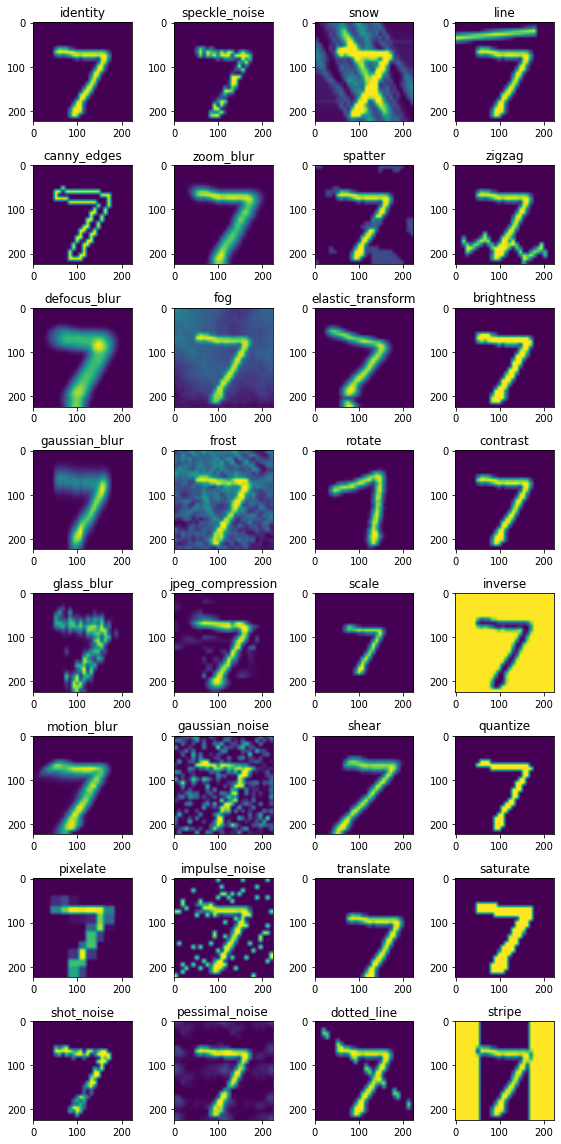

In [8]:
fig, axs = plt.subplots(8, 4, figsize=(2*4, 2*8))

for y in range(4):
    for x in range(8):        
        idx = x + 8 * y
        #variant = variants[idx]
        variant = ordered_variants[idx]
        is_improvement = variant_eval[variant]
        
        if is_improvement:
            cmap = 'viridis'
        else:
            cmap = 'gray'
        cmap='viridis'
        
        dataset = load_mnistc(variant)
        
        axs[x, y].imshow(dataset[0][0][0,...], cmap=cmap)
        axs[x, y].set_title(variant)
        
plt.tight_layout()
plt.savefig('tiny_lateral_net__image_examples.png')

In [44]:
cols = ['cnn_ft_acc_median', 'cnn_pt_acc_median', 'lcl_ft_acc_median', 'lcl_pt_acc_median']


x = df_imp['cnn_ft_acc_median'] - df_imp['cnn_ft_acc_std']
df_imp['cnn_ft_significant'] = ((x > (df_imp['lcl_ft_acc_median'] + df_imp['lcl_ft_acc_std'])) & (x > (df_imp['lcl_ft_d1_acc_median'] + df_imp['lcl_ft_d1_acc_std'])))
x = df_imp['cnn_pt_acc_median'] - df_imp['cnn_pt_acc_std']
df_imp['cnn_pt_significant'] = ((x > (df_imp['lcl_pt_acc_median'] + df_imp['lcl_pt_acc_std'])))

x = df_imp['lcl_ft_acc_median'] - df_imp['lcl_ft_acc_std']
df_imp['lcl_ft_significant'] = ((x > (df_imp['cnn_ft_acc_median'] + df_imp['cnn_ft_acc_std'])))
x = df_imp['lcl_pt_acc_median'] - df_imp['lcl_pt_acc_std']
df_imp['lcl_pt_significant'] = ((x > (df_imp['cnn_pt_acc_median'] + df_imp['cnn_pt_acc_std'])))
x = df_imp['lcl_ft_d1_acc_median'] - df_imp['lcl_ft_d1_acc_std']
df_imp['lcl_ft_d1_significant'] = ((x > (df_imp['cnn_ft_acc_median'] + df_imp['cnn_ft_acc_std'])))


def mc_reverse_index(val):
    return ordered_variants.index(val)

df_idx = pd.DataFrame(df_imp['mnist_c_variant'])
df_idx['reverse_index'] = df_imp['mnist_c_variant'].apply(mc_reverse_index)

df_imp = df_imp.iloc[df_idx.sort_values('reverse_index').index].reset_index(drop=True)
if 'group' not in df_imp.columns:
    df_imp.insert(1, 'group', ['-', 'LN', 'LN', 'LN', 'LN', 'LN', 'LN', 'LN', 'LN', 'LN', 'GN', 'GN', 'GN', 'GN', 'GN', 'GN', 'GN', 'GN', 'IT', 'IT', 'IT', 'IT', 'IT', 'SO', 'SO', 'SO', 'GIS', 'GIS', 'GIS', 'GIS', 'GIS', 'GIS'])

df_imp[['mnist_c_variant','cnn_ft_acc_median','cnn_pt_acc_median','lcl_ft_acc_median','lcl_pt_acc_median']]
df_imp

,mnist_c_variant,group,cnn_ft_acc_median,cnn_ft_acc_std,cnn_pt_acc_median,cnn_pt_acc_std,lcl_ft_acc_median,lcl_ft_acc_std,lcl_pt_acc_median,lcl_pt_acc_std,...,lcl_pt_significant,lcl_ft_d1_significant,cnn_ft>pt,cnn_ft<pt,lcl_ft>pt,lcl_ft<pt,lcl_ft_mean_higher,lcl_pt_mean_higher,cnn_ft_pt_diff,cnn_ft_pt_diff_perc
0,identity,-,0.9828,0.0017,0.9840,0.0008,0.9730,0.0047,0.9745,0.0019,...,False,False,False,False,False,False,False,True,-0.0012,-0.001221
1,canny_edges,LN,0.4488,0.0391,0.3905,0.0446,0.6471,0.1494,0.3168,0.0259,...,False,False,False,False,True,False,True,False,0.0583,0.129902
2,defocus_blur,LN,0.5768,0.0770,0.4314,0.0319,0.7884,0.0540,0.3226,0.0181,...,False,False,False,False,True,False,True,False,0.1454,0.252080
3,gaussian_blur,LN,0.6517,0.0581,0.5606,0.0171,0.8393,0.0451,0.4687,0.0094,...,False,False,False,False,True,False,True,False,0.0911,0.139788
4,glass_blur,LN,0.8600,0.0296,0.7617,0.0153,0.9114,0.0168,0.8164,0.0095,...,True,False,True,False,True,False,True,False,0.0983,0.114302
5,motion_blur,LN,0.8403,0.0382,0.7413,0.0217,0.8428,0.0409,0.6817,0.0415,...,False,False,True,False,True,False,True,False,0.0990,0.117815
6,pixelate,LN,0.9385,0.0090,0.9182,0.0045,0.9349,0.0166,0.9144,0.0076,...,False,False,True,False,False,False,True,False,0.0203,0.021630
7,shot_noise,LN,0.8806,0.0299,0.7551,0.0194,0.9627,0.0068,0.6663,0.0289,...,False,False,True,False,True,False,True,False,0.1255,0.142516
8,speckle_noise,LN,0.9107,0.0218,0.8172,0.0149,0.9653,0.0066,0.7388,0.0232,...,False,False,True,False,True,False,True,False,0.0935,0.102668
9,zoom_blur,LN,0.9300,0.0182,0.9086,0.0100,0.9186,0.0165,0.8438,0.0193,...,False,False,False,False,True,False,True,False,0.0214,0.023011


## Statistical Significance using Welch's t-test

In [49]:
df[(df['mnist_c_variant'] == 'identity') & (df['model_type'] == 'TinyLateralNet__FullyTrained__d1')]

,index,model,mnist_c_variant,accuracy,model_type
0,0,2022-07-05_110547,identity,0.9751,TinyLateralNet__FullyTrained__d1
448,0,2022-07-04_234855,identity,0.9821,TinyLateralNet__FullyTrained__d1
480,0,2022-07-04_234837,identity,0.9699,TinyLateralNet__FullyTrained__d1
544,0,2022-07-05_005834,identity,0.9749,TinyLateralNet__FullyTrained__d1
576,0,2022-07-04_234849,identity,0.9490,TinyLateralNet__FullyTrained__d1
736,0,2022-07-05_020317,identity,0.9126,TinyLateralNet__FullyTrained__d1
1120,0,2022-07-05_020904,identity,0.8925,TinyLateralNet__FullyTrained__d1
1216,0,2022-07-05_005822,identity,0.9784,TinyLateralNet__FullyTrained__d1


In [45]:
from scipy.stats import ttest_ind


val_a = df[(df['mnist_c_variant'] == 'identity') & (df['model_type'] == 'TinyCNN_FullyTrained')]['accuracy'].to_numpy()
val_b = df[(df['mnist_c_variant'] == 'identity') & (df['model_type'] == 'TinyLateralNet__FullyTrained')]['accuracy'].to_numpy()

ttest_ind(val_a, val_b, equal_var=False)

ttests = []
for variant in df_imp.mnist_c_variant.unique():
    tmp_df = df[df.mnist_c_variant == variant]

    tmp = {
        'mnist_c_variant': variant,
    }
    tmp['tcnn_ft_ttest'] = ttest_ind(tmp_df[tmp_df.model_type == 'TinyCNN_FullyTrained']['accuracy'], tmp_df[tmp_df.model_type == 'TinyLateralNet__FullyTrained']['accuracy'], equal_var=False, alternative='greater').pvalue < 0.05
    tmp['tcnn_ft_ttest__vs_d1'] = ttest_ind(tmp_df[tmp_df.model_type == 'TinyCNN_FullyTrained']['accuracy'], tmp_df[tmp_df.model_type == 'TinyLateralNet__FullyTrained__d1']['accuracy'], equal_var=False, alternative='greater').pvalue < 0.05
    tmp['tcnn_fp_ttest'] = ttest_ind(tmp_df[tmp_df.model_type == 'TinyCNN_PreTrained']['accuracy'], tmp_df[tmp_df.model_type == 'TinyLateralNet__PreTrained']['accuracy'], equal_var=False, alternative='greater').pvalue < 0.05
    
    tmp['tln_ft_ttest'] = ttest_ind(tmp_df[tmp_df.model_type == 'TinyLateralNet__FullyTrained']['accuracy'], tmp_df[tmp_df.model_type == 'TinyCNN_FullyTrained']['accuracy'], equal_var=False, alternative='greater').pvalue < 0.05
    tmp['tln_ft_d1_ttest'] = ttest_ind(tmp_df[tmp_df.model_type == 'TinyLateralNet__FullyTrained__d1']['accuracy'], tmp_df[tmp_df.model_type == 'TinyCNN_FullyTrained']['accuracy'], equal_var=False, alternative='greater').pvalue < 0.05
    tmp['tln_fp_ttest'] = ttest_ind(tmp_df[tmp_df.model_type == 'TinyLateralNet__PreTrained']['accuracy'], tmp_df[tmp_df.model_type == 'TinyCNN_PreTrained']['accuracy'], equal_var=False, alternative='greater').pvalue < 0.05
    
    tmp['tln_fp>tln_ft_ttest'] = ttest_ind(tmp_df[tmp_df.model_type == 'TinyLateralNet__PreTrained']['accuracy'], tmp_df[tmp_df.model_type == 'TinyLateralNet__FullyTrained']['accuracy'], equal_var=False, alternative='greater').pvalue < 0.05
    ttests.append(tmp)
    
print(df.model_type.unique())

pd.DataFrame(ttests)

['TinyLateralNet__FullyTrained__d1' 'TinyLateralNet__FullyTrained'
 'TinyLateralNet__PreTrained' 'TinyCNN_FullyTrained' 'TinyCNN_PreTrained']


,mnist_c_variant,tcnn_ft_ttest,tcnn_ft_ttest__vs_d1,tcnn_fp_ttest,tln_ft_ttest,tln_ft_d1_ttest,tln_fp_ttest,tln_fp>tln_ft_ttest
0,identity,True,True,True,False,False,False,False
1,canny_edges,False,False,True,True,True,False,False
2,defocus_blur,False,False,True,True,True,False,False
3,gaussian_blur,False,False,True,True,False,False,False
4,glass_blur,False,False,False,True,True,True,False
5,motion_blur,False,True,True,False,False,False,False
6,pixelate,False,False,False,False,False,False,False
7,shot_noise,False,False,True,True,True,False,False
8,speckle_noise,False,False,True,True,False,False,False
9,zoom_blur,False,True,True,False,False,False,False


In [14]:
df_imp['cnn_ft>pt'] = df_imp['cnn_ft_acc_median'] - df_imp['cnn_ft_acc_std'] > df_imp['cnn_pt_acc_median'] + df_imp['cnn_ft_acc_std']
df_imp['cnn_ft<pt'] = df_imp['cnn_ft_acc_median'] + df_imp['cnn_ft_acc_std'] < df_imp['cnn_pt_acc_median'] - df_imp['cnn_ft_acc_std']

df_imp['lcl_ft>pt'] = df_imp['lcl_ft_acc_median'] - df_imp['lcl_ft_acc_std'] > df_imp['lcl_pt_acc_median'] + df_imp['lcl_ft_acc_std']
df_imp['lcl_ft<pt'] = df_imp['lcl_ft_acc_median'] + df_imp['lcl_ft_acc_std'] < df_imp['lcl_pt_acc_median'] - df_imp['lcl_ft_acc_std']

df_imp['lcl_ft_mean_higher'] = df_imp['lcl_ft_acc_median'] > df_imp['lcl_pt_acc_median']
df_imp['lcl_pt_mean_higher'] = df_imp['lcl_pt_acc_median'] > df_imp['lcl_ft_acc_median']

df_imp['cnn_ft_pt_diff'] = df_imp['cnn_ft_acc_median'] - df_imp['cnn_pt_acc_median']
df_imp['cnn_ft_pt_diff_perc'] = (df_imp['cnn_ft_acc_median'] - df_imp['cnn_pt_acc_median']) / df_imp['cnn_ft_acc_median']

df_imp[['mnist_c_variant', 'lcl_ft>pt', 'lcl_ft_mean_higher', 'lcl_pt_mean_higher']]
df_imp[['mnist_c_variant', 'cnn_ft>pt', 'cnn_ft<pt', 'lcl_ft>pt', 'lcl_ft<pt']]

,mnist_c_variant,cnn_ft>pt,cnn_ft<pt,lcl_ft>pt,lcl_ft<pt
0,identity,False,False,False,False
1,canny_edges,False,False,True,False
2,defocus_blur,False,False,True,False
3,gaussian_blur,False,False,True,False
4,glass_blur,True,False,True,False
5,motion_blur,True,False,True,False
6,pixelate,True,False,False,False
7,shot_noise,True,False,True,False
8,speckle_noise,True,False,True,False
9,zoom_blur,False,False,True,False


In [8]:


a = df_cnn.groupby(['mnist_c_variant']).median()
a = a.reset_index()[['mnist_c_variant', 'accuracy']]
a.columns = ['mnist_c_variant', 'cnn_accuracy']

b = df_tln.groupby(['mnist_c_variant']).median()
b = b.reset_index()[['mnist_c_variant', 'accuracy']]
b.columns = ['mnist_c_variant', 'lcl_accuracy']

"""
a = df_cnn[['mnist_c_variant', 'accuracy']]
b = df_tln[['mnist_c_variant', 'accuracy']]
"""

dfx = pd.merge(a,b)
#dfx['improvement'] = dfx['cnn_accuracy'] < dfx['lcl_accuracy']
dfx['improvement%'] = 100 * (dfx['lcl_accuracy'] - dfx['cnn_accuracy']) / dfx['cnn_accuracy']
dfx['improvement%'] = dfx['improvement%'].round(2)

#print(dfx['improvement'].sum(), len(dfx), dfx['improvement'].sum()/len(dfx))

#dfx.sort_values('accuracy', ascending=False).reset_index(drop=True)
dfx.sort_values('improvement%', ascending=False).reset_index(drop=True)




,mnist_c_variant,cnn_accuracy,lcl_accuracy,improvement%
0,inverse,0.06885,0.09740,41.47
1,contrast,0.12755,0.16740,31.24
2,canny_edges,0.46540,0.60940,30.94
3,gaussian_blur,0.67615,0.85585,26.58
4,defocus_blur,0.64455,0.80955,25.60
5,shot_noise,0.85405,0.95620,11.96
6,speckle_noise,0.88795,0.96065,8.19
7,glass_blur,0.82895,0.89325,7.76
8,fog,0.48140,0.48510,0.77
9,quantize,0.96130,0.96295,0.17
